In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelBinarizer, scale
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import os
from sys import argv
import pdb

In [4]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'WZ' in f) and f[0] != '.']
    df = pd.DataFrame()

    for f in fs:
        print f
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))

    return df

In [5]:
def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

In [30]:
class WWdataset(Dataset):

    def __init__(self, pd_dataset):
        self.dataset = pd_dataset
        
        self.scale_dataset()
        
        self.input_vars = [col for col in self.dataset.columns if not col in ['runNumber', 'lbNumber', 'eventNumber', 'SFOS', 'is_sig', 'weight', 'cl', 'preds']]

        self.target_var = ['is_sig']
        self.weight_var = ['weight']
        
        self.input_np = self.dataset[self.input_vars].as_matrix().astype(dtype=np.float32)
        self.target_np = self.dataset[self.target_var].as_matrix().astype(dtype=int)
        self.weight_np =self.dataset[self.weight_var].as_matrix().astype(dtype=np.float32)

        self.inputs = torch.from_numpy(self.input_np)
        self.target = torch.from_numpy(self.target_np)
        self.weight = torch.from_numpy(self.weight_np)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        target = self.target[idx]
        weight = self.weight[idx]
        return inputs, target, weight

    def n_input(self):
        return len(self.input_vars)
    
    def scale_dataset(self):
        continuous_cols = [column for column in self.dataset.columns 
                           if self.dataset[column].dtype is np.dtype('float64') and column != 'weight']
        self.dataset[continuous_cols] = scale(self.dataset[continuous_cols])
        

In [7]:
def net_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 2),
    )
    return model

In [8]:
def net_deep_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 2),
    )
    return model

In [31]:
data_dir = "../../data/"
pandas_dataset = add_cl_ix(get_data(data_dir))

../../data/bkg_WZqqll.csv
../../data/signal_WmWpWm.csv
../../data/bkg_WZlvll.csv
../../data/signal_WpWpWm.csv


In [33]:
in_dataset = WWdataset(pandas_dataset)
trainloader = torch.utils.data.DataLoader(in_dataset, batch_size=200, shuffle=True, num_workers=2)

In [44]:
#net = net_logistic_regression(in_dataset.n_input())
net = net_deep_logistic_regression(in_dataset.n_input())
criterion = nn.CrossEntropyLoss(reduce=False)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

# Training

In [45]:
for epoch in range(5):
        print
        print "epoch: ", epoch
        running_loss = 0.
        for i, data in enumerate(trainloader):
            inputs, label, weight = data
            inputs, label, weight = Variable(inputs), Variable(label), Variable(weight)

            optimizer.zero_grad()
            output = net(inputs)
            losses = criterion(output, label.squeeze())
            loss = (losses * weight.squeeze()).sum()
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            if i % 200 == 199:    # print every 2000 mini-batches
                print "batch:  {}, loss: {}".format(i+1, running_loss/(i+1))


epoch:  0
batch:  200, loss: 0.273392267413
batch:  400, loss: 0.177675778503
batch:  600, loss: 0.145240123942
batch:  800, loss: 0.128749977527
batch:  1000, loss: 0.118475833867
batch:  1200, loss: 0.111790876271
batch:  1400, loss: 0.106821519586
batch:  1600, loss: 0.103101072626
batch:  1800, loss: 0.100117745983
batch:  2000, loss: 0.0977394067831
batch:  2200, loss: 0.0956995892643
batch:  2400, loss: 0.0939152046541
batch:  2600, loss: 0.0923818874373
batch:  2800, loss: 0.0911055384244

epoch:  1
batch:  200, loss: 0.0733827726729
batch:  400, loss: 0.0732797434181
batch:  600, loss: 0.0729283024619
batch:  800, loss: 0.0727077429462
batch:  1000, loss: 0.0725200481042
batch:  1200, loss: 0.0722914521862
batch:  1400, loss: 0.0719660890688
batch:  1600, loss: 0.0716311168065
batch:  1800, loss: 0.0712514266165
batch:  2000, loss: 0.0708538406026
batch:  2200, loss: 0.0705263593353
batch:  2400, loss: 0.0702160004402
batch:  2600, loss: 0.0699214476447
batch:  2800, loss: 0.0

# Prediction

In [46]:
input_for_pred = Variable(in_dataset.inputs)
predicted_scores = net(input_for_pred)
predicted_prob = nn.functional.softmax(predicted_scores, dim=1)

In [47]:
pandas_dataset['preds'] = predicted_prob.data.numpy()[:,1]

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in divide


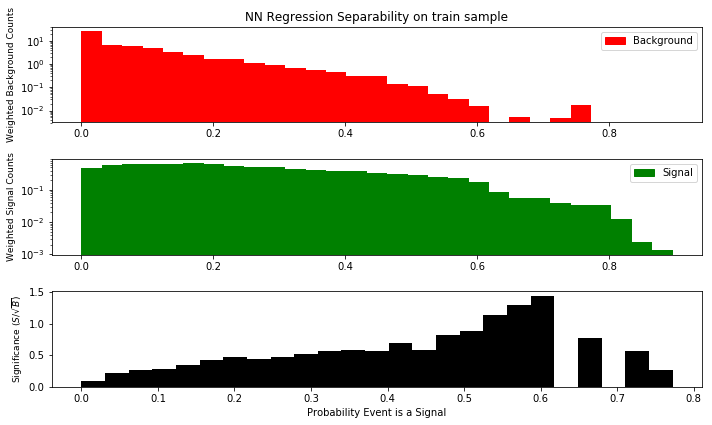

In [49]:
df = pandas_dataset
df = df[df['SFOS'] == 0] 

x_bins = np.linspace(0, max(df.preds), 30)
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0,:])
plt.title('NN Regression Separability on train sample')
# n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 0].weight.as_matrix(), color='r')
plt.yscale('log')
plt.ylabel(r'Weighted Background Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
ax1 = plt.subplot(gs[1,:])
n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 1].weight.as_matrix(), color='g')
plt.yscale('log')
plt.ylabel(r'Weighted Signal Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
ax2 = plt.subplot(gs[2,:])
plt.bar((x_bins[:-1] + x_bins[1:]) / 2., n_sig / np.sqrt(n_bkg), width=x_bins[1] - x_bins[0], color='k')
plt.ylabel(r'Significance ($S/\sqrt{B})$', size=9)
plt.xlabel('Probability Event is a Signal')

plt.tight_layout()
plt.show()
# plt.savefig("./plots/preds_train_nn_regression.pdf")

In [80]:
def n_sig_n_bkg(df, SF0S, n_bins, plot):
    df = df[df['SFOS'] == SF0S] 

    x_bins = np.linspace(0, 1, n_bins)
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    ax = plt.subplot(gs[0,:])
    plt.title('NN Regression Separability on train sample, SF0S = {}'.format(SF0S))
    # n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
    n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 0].weight.as_matrix(), color='r')
    plt.xlim([0, 1])
    plt.yscale('log')
    plt.ylabel(r'Weighted Background Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
    ax1 = plt.subplot(gs[1,:])
    n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 1].weight.as_matrix(), color='g')
    plt.xlim([0, 1])
    plt.yscale('log')
    plt.ylabel(r'Weighted Signal Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
    ax2 = plt.subplot(gs[2,:])
    plt.bar((x_bins[:-1] + x_bins[1:]) / 2., n_sig / np.sqrt(n_bkg), width=x_bins[1] - x_bins[0], color='k')
    plt.xlim([0, 1])
    plt.ylabel(r'Significance ($S/\sqrt{B})$', size=9)
    plt.xlabel('Probability Event is a Signal')

    plt.tight_layout()
    if plot==True:
        plt.show()
    return n_sig, n_bkg

In [ ]:
df = pandas_dataset

fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.title('NN Regression ROC')
plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show
plt.savefig("./plots/roc_curve_train_nn_regression.pdf")

# Developing

In [ ]:
# https://github.com/tongbaojia/MakePlot/blob/master/get_count.py#L780
# sensitivity = ROOT.TMath.Sqrt(2 * ((S + B) * ROOT.TMath.Log(1 + S / B) - S))
# sensitivity_err = (ROOT.TMath.Log(1 + S / B) * S_err + (ROOT.TMath.Log(1 + S / B) - S / B) * B_err) / sensitivity



/usr/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


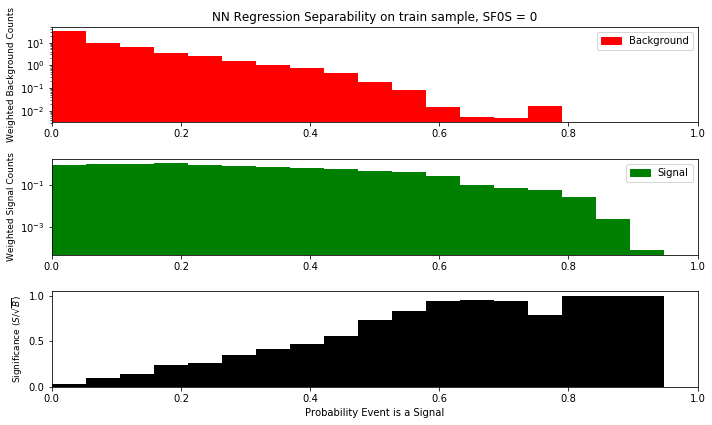

signficance with SF0S = 0 : 3.93350077026 sigma


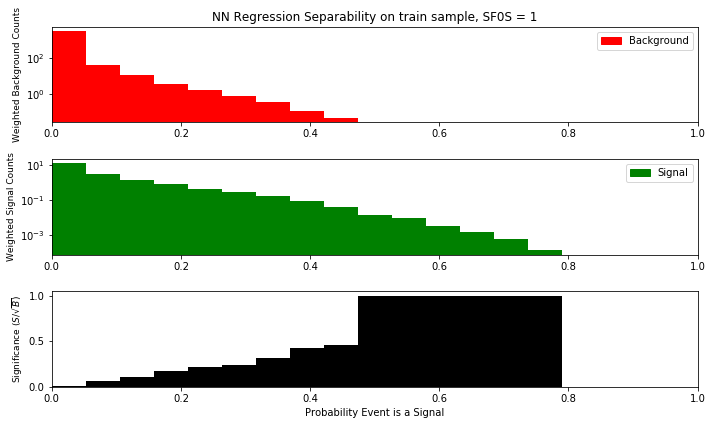

signficance with SF0S = 1 : 1.00553899032 sigma


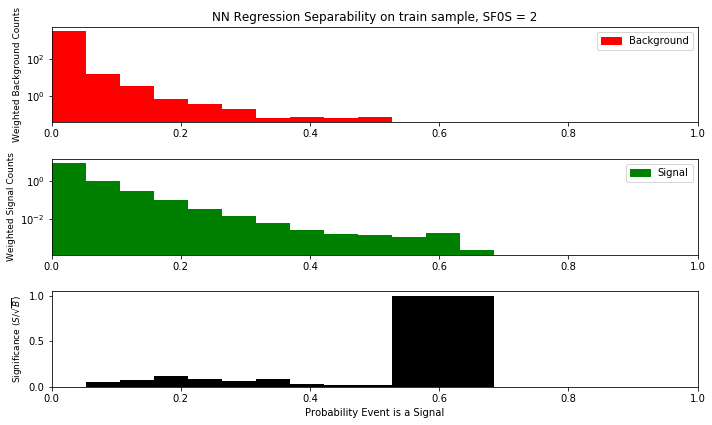

signficance with SF0S = 2 : 0.357789845173 sigma
combined significance: 4.07572699576


In [79]:
sign_combined = 0.
for SF0S in range(3):
    n_sig, n_bkg = n_sig_n_bkg(pandas_dataset, SF0S, n_bins=20, plot=True)
    
    total_significance = 0.
    for s, b in zip(n_sig, n_bkg):
        if b == 0:
            continue
        else:
            total_significance += s**2/b
    sign_combined += total_significance
    total_significance = np.sqrt(total_significance)
    print "signficance with SF0S = {} : {} sigma".format(SF0S, total_significance)

print "combined significance: {}".format(np.sqrt(sign_combined))